<b>Цель работы</b>  
Изучить возможность построения силовых линий поля для электростатической схемы с помощью численных методов<br><br>
<b>Постановка задачи</b>  
Построить силовые линии для указанной на рисунке электростатической системы. Красный электрод является положительно заряженным с зарядом Q, черный электрод является отрицательно заряженным электродом с зарядом -Q. Необходимо построить 20 силовых линий, которые начинаются на положительных электродах, Вся длина положительно заряженного электрода должна быть равномерно разбита на 20 интервалов, границы которых будут являться стартовыми точками силовых линий. Результат работы представить в виде картинки в любом из нижеперечисленных форматах: bmp, tiff, emf или jpeg  
Вариант 9<br><br>
<b>Ход работы</b><br>
Сначала зададим уравнения электродов. Для равномерного распределения точек уравнения описаны в полярной системе координат<br>
Первый электрод<br> 
$
\begin{cases}
    {x_1=5 \bullet cos(\phi) + 6}\\
    {y_1=5 \bullet sin(\phi) + 2}
\end{cases}\\
$  
Второй электрод<br>
$
\begin{cases}
    {x_1=1.25 \bullet cos(\phi) + 8.5}\\
    {y_1=1.25 \bullet sin(\phi) + 3}
\end{cases}
$<br>$
\begin{cases}
    {x_2=1.25 \bullet cos(\phi+\pi) + 8.5}\\
    {y_2=1.25 \bullet sin(\phi+\pi) + 3}
\end{cases}\\
$
<br>Итерация:<br>
$
N = 3000;
\phi \in [\frac 0 \pi \bullet N, \frac 1 \pi \bullet N, ..., \pi]
$

In [35]:
import math
import numpy as np

N = 5000

def get_half_circle(cX, cY, R, sign, num=N):
    res = []
    start_angle = 0 if sign == 1 else math.pi
    for angle in np.linspace(start_angle, start_angle + math.pi, num):
        dX = R * math.cos(angle)
        dY = R * math.sin(angle)
        res.append(((cX + dX), (cY + dY)))
    return res

get_coords_lists = lambda space: (
    [coords[0] for coords in space],
    [coords[1] for coords in space]
)

e1_space = get_half_circle(6, 2, 5, 1)#, int(N / 2)) +get_half_circle(6, 2, 5, -1, int(N / 2))
e2_space = get_half_circle(8.5, 3, 1.25, 1, int(N / 2)) + get_half_circle(8.5, 3, 1.25, -1, int(N / 2))
e1_x, e1_y = get_coords_lists(e1_space)
e2_x, e2_y = get_coords_lists(e2_space)

Проведём построение, чтобы убедится в правильности<br>
Коды в основном вынесены в функцию, чтобы избежать пересечения namespace'ов

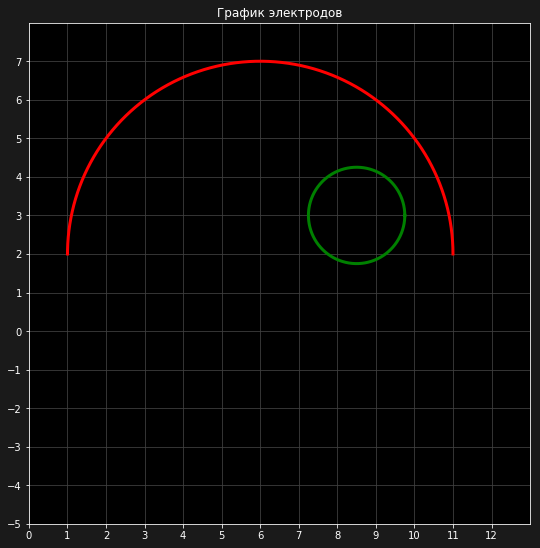

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

def init_figure(num):
    figure = plt.figure(num=num, figsize=(8,8), facecolor='0.1')
    axes = figure.add_axes([0.1, 0.1, 0.87, 0.87])
    axes.set_title('График электродов')
    axes.set_xlim(0, 13)
    axes.set_ylim(-5, 8)
    axes.set_xticks(np.arange(13))
    axes.set_yticks(np.arange(-5, 8))
    axes.grid(color='0.25')
    return figure, axes

def draw_electrodes(figure, axes):
    axes.plot(e1_x, e1_y, linewidth=3.0, color='r')
    axes.plot(e2_x, e2_y, linewidth=3.0, color='g')
    return figure, axes

graph = init_figure(0)
draw_electrodes(*graph)
plt.show()

Произведем построение силовых линий. Для этого нужно выбрать 20 стартовых точек в непосредственой близости от второго электрода. Благодаря вычислению окружностей через полярную системе координат точки распределены по окружности равномерно

In [45]:
def get_start_points(space, num, cX, cY):
    res = []
    res_on_circle = []
    for i in range(0, len(space), int(len(space) / num)):
        dX, dY = space[i][0] - cX, space[i][1] - cY
        res_on_circle.append((dX + cX, dY + cY))
        dX, dY = dX * 1.06 + cX, dY * 1.06 + cY
        res.append((dX, dY))
    return res, res_on_circle

start_points, circle_points = get_start_points(e2_space, 20, 8.5, 3)

Проверим корректность полученных точек

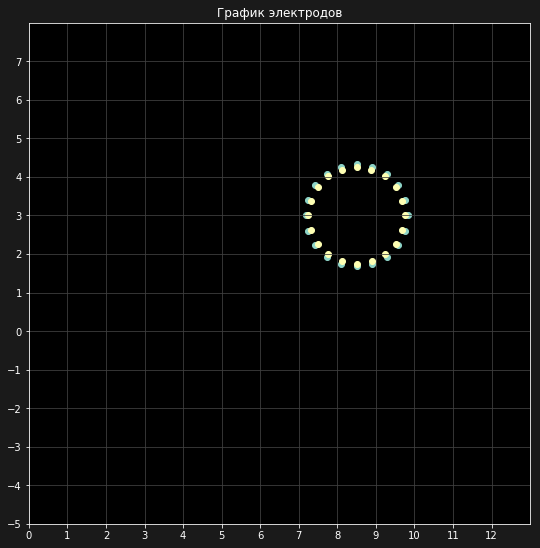

In [46]:
def check_points(figure, axes, points):
    x_s, y_s = get_coords_lists(points)
    axes.scatter(x_s, y_s)
    return figure, axes

graph = init_figure(1)
graph = check_points(*graph, start_points)
graph = check_points(*graph, circle_points)
plt.show()

Напишем декоратор, измеряющий время выполнения

In [ ]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        print(f'{func.__name__} started at PID {os.getpid()}')
        start = timer()
        res = func(*args, **kwargs)
        end = timer()
        print(f'{func.__name__} at PID {os.getpid()} exectuted for {(end - start):.4f} seconds')
        return res
    return wrapper

Теперь определим, как будут вычисляться значения следующих точек

In [52]:
distance = lambda x1, y1, x2, y2: math.sqrt((x2-x1)**2 + (y2-y1)**2)

def get_next_point(x, y):
    inc_p = lambda p1, p2: (
        lambda: (
            lambda φ=np.arctan2((p1[0] - p2[0]), (p1[1] - p2[1])): (
                ( 
                    (np.sin(φ)) / (distance(*p1, *p2) ** 2),
                    (np.cos(φ)) / (distance(*p1, *p2) ** 2)
                )
            )
            if distance(*p1, *p2) != 0 else 0
        )()
    )()
    p = (x, y)
    new_x, new_y = 0, 0
    for p1, p2 in zip(e1_space, e2_space):
        dx, dy = inc_p(p, p1)
        new_x -= dx
        new_y -= dy
        dx, dy = inc_p(p, p2)
        new_x += dx
        new_y += dy
    #print(dx, dy)
    new_x, new_y = x + new_x * 0.00003, y + new_y * 0.00003
    return new_x, new_y

@measure_time
def get_line(x, y):
    from datetime import datetime
    #print(f"Started line {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    line = []
    p = (x, y)
    i = 0
    while distance(*p, 6, 2) <= 5 and i < 1000:
        line.append(p)
        p = get_next_point(*p)
        #print(distance(*p, 6, 2), p)
        i += 1
    return line

Теперь можно вычислить и построить силовые линии

In [62]:
import concurrent.futures
import os
from timeit import default_timer as timer

def get_line_p(point):
    return get_line(*point)

@measure_time
def count_lines():
    with concurrent.futures.ProcessPoolExecutor() as executor:
        lines = executor.map(get_line_p, start_points)
        return lines

lines = list(count_lines())

count_lines started at PID 9467
get_line started at PID 13457
get_line started at PID 13458
get_line started at PID 13460
get_line started at PID 13459
get_line started at PID 13461
get_line started at PID 13462
get_line started at PID 13463
get_line started at PID 13464
get_line exectuted for 0.8462 seconds
get_line started at PID 13458
get_line exectuted for 0.8819 seconds
get_line started at PID 13459
get_line exectuted for 1.3840 seconds
get_line started at PID 13457
get_line exectuted for 1.3890 seconds
get_line started at PID 13460
get_line exectuted for 2.1912 seconds
get_line started at PID 13461
get_line exectuted for 4.5191 seconds
get_line started at PID 13462
get_line exectuted for 7.7195 seconds
get_line started at PID 13463
get_line exectuted for 12.8948 seconds
get_line started at PID 13464
get_line exectuted for 24.3742 seconds
get_line started at PID 13458
get_line exectuted for 38.9512 seconds
get_line started at PID 13459
get_line exectuted for 54.6631 seconds
get_li

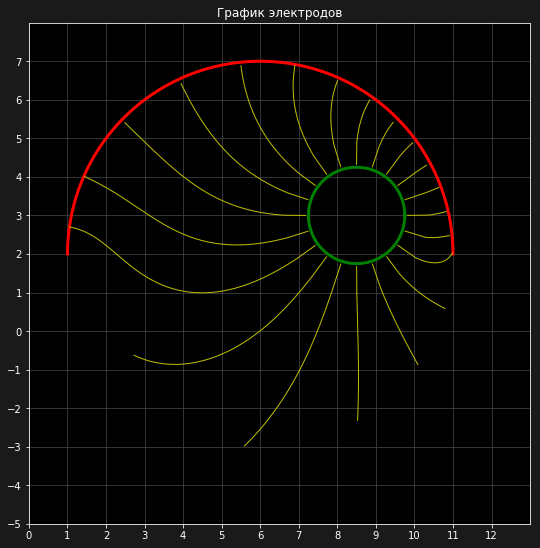

In [63]:
#lines = [[circle_points[i]] + pre_lines[i] for i in range(len(pre_lines))]
def draw_force_lines(figure, axes):
    for line in lines:
        axes.plot(*get_coords_lists(line), color='y', lw=1)
    return figure, axes

graph = init_figure(2)
graph = draw_electrodes(*graph)
#graph = check_points(*graph, circle_points)
#graph = check_points(*graph, start_points)
graph = draw_force_lines(*graph)
plt.show()

<b>Вывод</b>  
Изучены возможности построения силовых линий численными методами с помощью средств языка Python и библиотек numpy и matplotlib